In [1]:
import sys
sys.path.append('../')
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import seaborn as sns
from scipy.spatial.distance import cdist
from utils.utils import *
from utils.ccf_utils import *
from scipy import stats, spatial
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
#plt.rcParams['font.family'] = 'Arial'

from scipy.optimize import curve_fit
from math import log
from scipy.special import logsumexp
from scipy.optimize import minimize_scalar
# from scipy import optimize, stats

from scipy.stats import norm, lognorm, beta, poisson
from scipy.optimize import minimize

major_list = ['Isocortex', 'OLF','HPF', 'CTXsp', 'STR',
              'PAL','TH', 'HY', 'MB', 'P','MY', 'CBX',]

import json
with open('../../data/region2primaryRegion.json', 'r') as f:
    detailRegion2rough = json.load(f)

# =========================
# 1) 截断分布的PMF集合
# =========================

def _normalize_trunc(probs):
    s = probs.sum()
    return probs / s if s > 0 else probs

def pmf_trunc_poisson(k, lam):
    raw = stats.poisson.pmf(k, mu=lam)
    return raw

def pmf_trunc_nbinom(k, r, p):
    # r>0, p∈(0,1). SciPy 负二项参数化：nbinom(r, p) 为 “成功概率p、需要r次成功前失败数”的分布，支持0,1,2...
    # 我们直接取 k 的概率并截断归一化
    raw = stats.nbinom.pmf(k, n=r, p=p)
    return raw

def pmf_trunc_geom(k, p):
    # 几何分布支持从1开始：P(K=k) = (1-p)^(k-1) * p
    raw = (1 - p) ** (k - 1) * p
    return raw

def pmf_trunc_logseries(k, theta):
    # 对数级数：P(K=k) = -1/ln(1-theta) * theta^k / k, k>=1, 0<theta<1
    # 直接依式计算并截断归一化
    raw = -1.0 / np.log(1 - theta) * (theta ** k) / k
    return raw

def pmf_trunc_dlognorm(k, mu, sigma):
    # 离散对数正态：用连续Lognormal在半整数区间积分近似
    # 概率 ~ CDF(k+0.5) - CDF(k-0.5)，k>=1
    # 注意：sigma>0
    k = np.asarray(k)
    lo = np.maximum(0.5, k - 0.5)  # 下界不小于0.5
    hi = k + 0.5
    cdf = stats.lognorm.cdf
    raw = cdf(hi, s=sigma, scale=np.exp(mu)) - cdf(lo, s=sigma, scale=np.exp(mu))
    return raw

# 统一接口：返回k_min..k_max上的截断概率
def truncated_probs(model, params, k_min=1, k_max=10):
    k = np.arange(k_min, k_max + 1)
    if model == "poisson":
        raw = pmf_trunc_poisson(k, params["lam"])
    elif model == "nbinom":
        raw = pmf_trunc_nbinom(k, params["r"], params["p"])
    elif model == "geom":
        raw = pmf_trunc_geom(k, params["p"])
    elif model == "logseries":
        raw = pmf_trunc_logseries(k, params["theta"])
    elif model == "dlognorm":
        raw = pmf_trunc_dlognorm(k, params["mu"], params["sigma"])
    else:
        raise ValueError("Unknown model")
    return _normalize_trunc(raw)

# =========================
# 2) 拟合：最小化交叉熵/负对数似然
# =========================

def _cross_entropy(p_obs, p_model, eps=1e-12):
    p_model = np.clip(p_model, eps, 1.0)  # 避免log(0)
    return -np.sum(p_obs * np.log(p_model))

def _fit_model(observed_probs, model, k_min=1, k_max=10):
    # 根据模型设置参数与边界；目标函数 = 交叉熵（等价于用比例做的NLL/样本数）
    if model == "poisson":
        x0 = [max(0.1, np.dot(np.arange(k_min, k_max+1), observed_probs))]  # 初值≈均值
        bounds = [(1e-3, 50)]
        def unpack(x): return {"lam": x[0]}
    elif model == "nbinom":
        x0 = [1.5, 0.5]        # r, p
        bounds = [(1e-3, 100), (1e-4, 1-1e-4)]
        def unpack(x): return {"r": x[0], "p": x[1]}
    elif model == "geom":
        x0 = [0.3]
        bounds = [(1e-4, 1-1e-4)]
        def unpack(x): return {"p": x[0]}
    elif model == "logseries":
        x0 = [0.7]
        bounds = [(1e-4, 1-1e-4)]
        def unpack(x): return {"theta": x[0]}
    elif model == "dlognorm":
        # 用log(k)的均值方差来给mu/sigma初值
        ks = np.arange(k_min, k_max+1)
        m = np.sum(observed_probs * np.log(ks + 1e-9))
        v = np.sum(observed_probs * (np.log(ks + 1e-9) - m)**2)
        x0 = [m, max(0.3, np.sqrt(max(v, 1e-6)))]
        bounds = [(-5, 5), (1e-3, 5)]
        def unpack(x): return {"mu": x[0], "sigma": x[1]}
    else:
        raise ValueError("Unknown model")

    def objective(x):
        params = unpack(x)
        p_model = truncated_probs(model, params, k_min, k_max)
        return _cross_entropy(observed_probs, p_model)

    res = minimize(objective, x0=x0, bounds=bounds, method="L-BFGS-B")
    return unpack(res.x), res.fun, res.success, res

# =========================
# 3) 评估指标：KL/AIC/BIC/卡方
# =========================

def evaluate_model(observed_probs, model_probs, num_params, total_count=None):
    """
    observed_probs: 观测比例(和为1)
    model_probs:    模型概率(和为1)
    num_params:     模型参数个数
    total_count:    若提供（观测总样本数/突触总数），AIC/BIC和卡方将用它进行尺度化
    """
    ce = _cross_entropy(observed_probs, model_probs)        # 交叉熵
    kl = ce - (-np.sum(observed_probs * np.log(np.clip(observed_probs,1e-12,1.0))))  # KL(obs||model)

    # AIC/BIC 需要总样本数来计算NLL = N * CE
    if total_count is not None and total_count > 0:
        nll = total_count * ce
        aic = 2 * num_params + 2 * nll
        bic = num_params * log(total_count) + 2 * nll
        # 卡方检验（期望频数 = N * model_probs）
        obs_counts = observed_probs * total_count
        exp_counts = model_probs * total_count
        # 为避免0格，做一个轻微平滑
        exp_counts = np.clip(exp_counts, 1e-8, None)
        chi2_stat = ((obs_counts - exp_counts)**2 / exp_counts).sum()
        dof = (len(model_probs) - 1 - num_params)
        p_value = 1 - stats.chi2.cdf(chi2_stat, max(dof,1))
    else:
        aic = bic = None
        chi2_stat = p_value = None

    return {
        "CE": ce,
        "KL": kl,
        "AIC": aic,
        "BIC": bic,
        "chi2": chi2_stat,
        "chi2_p": p_value
    }

# =========================
# 4) 一键拟合与模型选择
# =========================

def fit_and_compare(observed, k_min=1, k_max=10, total_count=None):
    """
    observed: 可以是概率(和为1)或频数(自动归一)
    total_count: 若传入频数则可省略；若传入概率但你知道总样本数，填这里以开启AIC/BIC/卡方
    """
    observed = np.asarray(observed, dtype=float)
    if not np.isclose(observed.sum(), 1.0):
        if observed.sum() <= 0:
            raise ValueError("Observed data must be positive.")
        if total_count is None:
            total_count = observed.sum()
        observed_probs = observed / observed.sum()
    else:
        observed_probs = observed
        # total_count 可由用户单独提供（若需要AIC/BIC/卡方）

    models = [
        ("poisson",   1),
        ("nbinom",    2),
        ("geom",      1),
        ("logseries", 1),
        ("dlognorm",  2),
    ]

    results = {}
    for name, kparams in models:
        params, ce, ok, raw = _fit_model(observed_probs, name, k_min, k_max)
        p_model = truncated_probs(name, params, k_min, k_max)
        metrics = evaluate_model(observed_probs, p_model, kparams, total_count)
        results[name] = {
            "params": params,
            "probs": p_model,
            "CE": metrics["CE"],
            "KL": metrics["KL"],
            "AIC": metrics["AIC"],
            "BIC": metrics["BIC"],
            "chi2": metrics["chi2"],
            "chi2_p": metrics["chi2_p"],
            "opt_success": ok
        }

    # 选择准则：优先 BIC（若有N），否则 KL（或CE）
    if any(results[m]["BIC"] is not None for m in results):
        best = min(results.items(), key=lambda kv: kv[1]["BIC"] if kv[1]["BIC"] is not None else np.inf)
    else:
        best = min(results.items(), key=lambda kv: kv[1]["KL"])

    best_name, best_info = best
    return best_name, best_info, results

In [2]:
soma_feature = pd.read_csv('../../data/155k_DEN_soma_feature.csv', 
                           sep=',', index_col=0)
# soma_feature.set_index('swc_id', inplace=True)
soma_feature

,x,y,z,source_region,source_region_withCorticalRegion
swc_id,,,,,
SEU-ALLEN_local_15257_10001_19868_8155_CCFv3.swc,11287.600,3667.825,5563.125,fiber tracts,arb
SEU-ALLEN_local_15257_10008_10862_6996_CCFv3.swc,9625.025,3764.025,9017.726,ENTm,ENTm5
SEU-ALLEN_local_15257_10012_10978_7039_CCFv3.swc,9682.675,3754.125,8985.000,ENTm,ENTm5
SEU-ALLEN_local_15257_10020_17924_8129_CCFv3.swc,11267.750,3630.950,6364.775,fiber tracts,arb
SEU-ALLEN_local_15257_10028_28224_6732_CCFv3.swc,9298.925,3983.150,2374.200,SUB,SUB
...,...,...,...,...,...
SEU-ALLEN_local_236174_7626_18076_3068_CCFv3.swc,3998.550,1907.975,5585.175,ACAd,ACAd1
SEU-ALLEN_local_236174_8122_17844_3762_CCFv3.swc,4842.475,2017.425,5512.275,ACAd,ACAd2/3
SEU-ALLEN_local_236174_8813_17916_4826_CCFv3.swc,5990.175,2143.925,5498.300,ACAv,ACAv2/3


In [3]:
den_contact = pd.read_csv('../../data/ppss_from_pacs.csv', sep=',', index_col=0)

den_contact

,Unnamed: 0,x,y,z,source_cell,target_cell,branch_level,target_region,color
0,0,6719.33,4732.66,4685.44,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
1,1,6719.74,4733.37,4685.04,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
2,2,6720.34,4733.72,4684.31,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
3,3,6720.94,4734.06,4683.59,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
4,4,6686.39,4743.11,4648.30,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,6,VAL,#acc2d9
...,...,...,...,...,...,...,...,...,...
17995300,22299324,3283.52,3644.60,8860.40,pre_18868_00465,SEU-ALLEN_local_201584_8835_21199_4542_CCFv3.swc,9,MOp,#1f77b4
17995301,22299325,3283.40,3647.35,8860.64,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995302,22299326,3283.27,3646.37,8860.83,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995303,22299327,3283.14,3645.40,8861.01,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4


In [4]:
# soma_feature = soma_feature.loc[den_contact['target_cell'].unique(), :]
soma_feature = soma_feature[soma_feature['source_region'].isin(list(den_contact['target_region'].unique()))].copy()
soma_ct = soma_feature['source_region'].value_counts()
del soma_ct['fiber tracts']
# soma_ct = soma_ct[0:15]
soma_ct = soma_ct[soma_ct>=30]
soma_ct

source_region
CP     21802
MOB    16644
IC      6709
AN      4770
CUL     4444
       ...  
SNc       32
APN       32
CA2       31
FN        31
SMT       30
Name: count, Length: 175, dtype: int64

In [5]:
sele_region = detailRegion2rough.keys()
order_list = []

for i in sele_region:
    if i in list(soma_ct.index):
        order_list.append(i)

# order_list = ['MOp', 'MOs', 'SSp-n', 'SSp-bfd', 'SSs', 'AUDp', 
#               'VISp', 'CA1', 'DG', 'POST', 'CP', 'OT', 'MEA', 
#               'GPe', 'BST', 'VPL', 'VPM', 'LGd', 'SNr', 'MRN',
#               'PAG']

print(order_list)
print(len(order_list))

['FRP', 'MOp', 'MOs', 'SSp-n', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-ul', 'SSp-tr', 'SSp-un', 'SSs', 'GU', 'VISC', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'VISal', 'VISam', 'VISl', 'VISp', 'VISpl', 'VISpm', 'VISli', 'VISpor', 'ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'AId', 'AIp', 'AIv', 'RSPagl', 'RSPd', 'RSPv', 'VISa', 'VISrl', 'TEa', 'PERI', 'ECT', 'MOB', 'AOB', 'AON', 'TT', 'DP', 'PIR', 'NLOT', 'COAa', 'COAp', 'PAA', 'TR', 'CA1', 'CA2', 'CA3', 'DG', 'ENTl', 'ENTm', 'PAR', 'POST', 'PRE', 'SUB', 'ProS', 'HATA', 'APr', 'CLA', 'EPd', 'EPv', 'LA', 'BLA', 'BMA', 'PA', 'CP', 'ACB', 'FS', 'OT', 'LSc', 'LSr', 'LSv', 'SF', 'AAA', 'CEA', 'IA', 'MEA', 'GPe', 'SI', 'MA', 'MS', 'NDB', 'TRS', 'BST', 'VM', 'VPL', 'VPM', 'MG', 'LGd', 'LP', 'PO', 'AM', 'MD', 'SMT', 'PVT', 'PT', 'RE', 'CM', 'RT', 'IGL', 'LGv', 'ARH', 'DMH', 'MPO', 'SBPV', 'SCH', 'AHN', 'TMv', 'MPN', 'PMv', 'PH', 'LHA', 'PSTN', 'TU', 'ZI', 'SCs', 'IC', 'SNr', 'VTA', 'MRN', 'SCm', 'PAG', 'APN', 'SNc', 'DR', 'NLL', 'PSV', 'PB', 'SOC',

## branch-level distribution in same source regions

In [6]:
den_contact = den_contact[den_contact['target_region'].isin(order_list)]
den_contact

,Unnamed: 0,x,y,z,source_cell,target_cell,branch_level,target_region,color
20,20,2963.27,2784.95,3914.27,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_9293_13363_2479_CCFv3.swc,8,MOs,#56ae57
21,21,2810.66,2770.75,3799.39,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
22,22,2811.53,2770.50,3798.97,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
23,23,2812.41,2770.25,3798.56,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
24,24,2813.28,2770.00,3798.14,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
...,...,...,...,...,...,...,...,...,...
17995300,22299324,3283.52,3644.60,8860.40,pre_18868_00465,SEU-ALLEN_local_201584_8835_21199_4542_CCFv3.swc,9,MOp,#1f77b4
17995301,22299325,3283.40,3647.35,8860.64,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995302,22299326,3283.27,3646.37,8860.83,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995303,22299327,3283.14,3645.40,8861.01,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4


In [7]:
den_contact.loc[:, 'count'] = 1

wide_df2_ = den_contact.pivot_table(index='target_region', columns=['branch_level'], 
                        values=['count'], aggfunc='sum', fill_value=0
                       )

wide_df2_.columns.name = ''
wide_df2_.columns = [i[1] for i in wide_df2_.columns]
wide_df2_.index.name = ''
wide_df2_

C:\Users\yishui\AppData\Local\Temp\ipykernel_33980\2991686258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  den_contact.loc[:, 'count'] = 1


,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
,,,,,,,,,,,,,,,,,,,,,
AAA,144,673,853,823,829,399,335,121,55,26,...,0,0,0,0,0,0,0,0,0,0
ACAd,3665,11133,22013,31999,32171,25411,19162,12339,6836,4134,...,142,29,0,0,0,0,0,0,0,0
ACAv,3036,8519,15984,19129,19563,17962,13964,9883,5966,3474,...,198,45,84,26,22,0,0,0,0,0
ACB,35287,113875,214127,286363,289798,236846,164850,94084,49795,25866,...,1258,329,165,126,14,0,0,0,0,0
AHN,367,1803,2026,2249,1289,603,282,192,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM,1266,4916,10949,18066,24360,25883,22083,17962,10437,5787,...,136,99,9,0,0,0,0,0,0,0
VPL,445,2387,3129,2718,3789,3710,2792,2853,1707,856,...,87,9,0,0,0,0,0,0,0,0
VPM,1638,5430,6753,7372,8506,7042,6135,4801,3161,1427,...,50,49,8,4,0,0,0,0,0,0


In [8]:
wide_df2 = wide_df2_.copy()

for i in wide_df2.index:
   wide_df2.loc[i, :] = wide_df2.loc[i, :] / soma_ct[i]

wide_df2

C:\Users\yishui\AppData\Local\Temp\ipykernel_33980\1929942465.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wide_df2.loc[i, :] = wide_df2.loc[i, :] / soma_ct[i]
C:\Users\yishui\AppData\Local\Temp\ipykernel_33980\1929942465.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.010416666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wide_df2.loc[i, :] = wide_df2.loc[i, :] / soma_ct[i]
C:\Users\yishui\AppData\Local\Temp\ipykernel_33980\1929942465.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.885416666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
,,,,,,,,,,,,,,,,,,,,,
AAA,1.500000,7.010417,8.885417,8.572917,8.635417,4.156250,3.489583,1.260417,0.572917,0.270833,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ACAd,10.237430,31.097765,61.488827,89.382682,89.863128,70.980447,53.525140,34.466480,19.094972,11.547486,...,0.396648,0.081006,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ACAv,8.183288,22.962264,43.083558,51.560647,52.730458,48.415094,37.638814,26.638814,16.080863,9.363881,...,0.533693,0.121294,0.226415,0.070081,0.059299,0.0,0.0,0.0,0.0,0.0
ACB,10.820914,34.920270,65.662987,87.814474,88.867832,72.629868,50.551978,28.851273,15.269856,7.931923,...,0.385771,0.100889,0.050598,0.038638,0.004293,0.0,0.0,0.0,0.0,0.0
AHN,7.196078,35.352941,39.725490,44.098039,25.274510,11.823529,5.529412,3.764706,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM,7.072626,27.463687,61.167598,100.927374,136.089385,144.597765,123.368715,100.346369,58.307263,32.329609,...,0.759777,0.553073,0.050279,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
VPL,1.236111,6.630556,8.691667,7.550000,10.525000,10.305556,7.755556,7.925000,4.741667,2.377778,...,0.241667,0.025000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
VPM,2.017241,6.687192,8.316502,9.078818,10.475369,8.672414,7.555419,5.912562,3.892857,1.757389,...,0.061576,0.060345,0.009852,0.004926,0.000000,0.0,0.0,0.0,0.0,0.0


In [9]:
# wide_df2 = wide_df2.loc[:, list(range(1, 11))]
# # wide_df2 = (wide_df2.T / wide_df2.sum(axis=1)).T
# wide_df2

In [10]:
for i in range(1, max(wide_df2.columns)+1):
    if i not in list(wide_df2.columns):
        wide_df2[i] = 0

wide_df2 = wide_df2.loc[order_list, list(range(1, 11))]
wide_df2

,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,
FRP,9.309091,35.090909,68.527273,93.400000,101.600000,71.472727,51.472727,48.454545,24.672727,16.527273
MOp,1.762687,6.975124,13.797015,19.267164,21.997015,20.454726,16.844776,11.687562,7.549751,4.971642
MOs,4.697613,17.094164,32.365385,46.782493,53.625332,47.896552,38.299735,25.527188,16.180371,9.777188
SSp-n,1.948454,7.485825,13.451031,20.086340,19.650773,17.911082,14.207474,10.435567,6.953608,3.372423
SSp-bfd,2.125155,7.546468,14.231103,18.999380,20.583643,17.689591,13.698265,9.479554,6.337670,3.306691
...,...,...,...,...,...,...,...,...,...,...
SIM,0.000330,0.010234,0.004622,0.001651,0.003632,0.006273,0.000660,0.002641,0.001981,0.000000
AN,0.004822,0.008595,0.005241,0.003354,0.002096,0.000000,0.000000,0.000000,0.000000,0.000000
COPY,0.000000,0.000000,0.000000,0.018265,0.009132,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
lambda_df1 = pd.DataFrame()
test_models = ['poisson', 'nbinom', 'geom', 
               'logseries', 'dlognorm']

for i in tqdm(wide_df2.index):
    tmp_observed_counts = wide_df2.loc[i, :]
    
    tmp_total_N = tmp_observed_counts.sum()
    tmp_observed_probs = tmp_observed_counts / tmp_total_N
    
    best_name, best_info, all_results = fit_and_compare(
        tmp_observed_probs, k_min=1, k_max=10, total_count=tmp_total_N
    )

    lambda_df1 = pd.concat([lambda_df1, 
                           pd.DataFrame({'region': [i]*len(test_models), 
                                         'dist': test_models, 
                                         'BIC': [all_results[m]['BIC'] for m in test_models]
                                         }), 
                          ], axis=0)



lambda_df1['major_region'] = lambda_df1['region'].map(detailRegion2rough)
lambda_df1

100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [00:08<00:00, 19.92it/s]


,region,dist,BIC,major_region
0,FRP,poisson,2226.376234,Isocortex
1,FRP,nbinom,2232.916792,Isocortex
2,FRP,geom,2399.303583,Isocortex
3,FRP,logseries,2752.926040,Isocortex
4,FRP,dlognorm,2235.790627,Isocortex
...,...,...,...,...
0,FL,poisson,-3.825493,CBX
1,FL,nbinom,-7.716940,CBX
2,FL,geom,-3.810978,CBX
3,FL,logseries,-3.801720,CBX


In [12]:
best_df = lambda_df1.loc[lambda_df1.groupby('major_region')['BIC'].idxmin()].reset_index(drop=True)
prop_table = pd.crosstab(best_df['major_region'],
                         best_df['dist'],
                         normalize='index') 

prop_table

dist,dlognorm,poisson
major_region,,
CBX,0.25,0.75
CTXsp,0.25,0.75
HPF,0.25,0.75
HY,0.25,0.75
Isocortex,0.25,0.75
MB,0.25,0.75
MY,0.25,0.75
OLF,0.25,0.75
P,0.25,0.75


In [13]:
results = []
for i in np.unique(lambda_df1.region.unique()):
    tmp_df = lambda_df1[lambda_df1['region']==i]
    tmp_min = np.min(tmp_df['BIC'])
    print(tmp_df.loc[tmp_df['BIC']==tmp_min, 'dist'])
    results.append(tmp_df.loc[tmp_df['BIC']==tmp_min, 'dist'])

results

0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
4    dlognorm
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
4    dlognorm
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist, dtype: object
0    poisson
Name: dist

[0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 4    dlognorm
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 4    dlognorm
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype: object,
 0    poisson
 Name: dist, dtype

In [14]:
def _normalize_trunc(probs):
    s = probs.sum()
    return probs / s if s > 0 else probs

def pmf_trunc_poisson(k, lam):
    raw = stats.poisson.pmf(k, mu=lam)
    return raw

def truncated_probs(model, params, k_min=1, k_max=10):
    k = np.arange(k_min, k_max + 1)
    if model == "poisson":
        raw = pmf_trunc_poisson(k, params["lam"])
    return _normalize_trunc(raw)

def _cross_entropy(p_obs, p_model, eps=1e-12):
    p_model = np.clip(p_model, eps, 1.0)
    return -np.sum(p_obs * np.log(p_model))

def _fit_model(observed_probs, model, k_min=1, k_max=10):
    if model == "poisson":
        x0 = [max(0.1, np.dot(np.arange(k_min, k_max+1), observed_probs))]
        bounds = [(1e-3, 50)]
        def unpack(x): return {"lam": x[0]}
    def objective(x):
        params = unpack(x)
        p_model = truncated_probs(model, params, k_min, k_max)
        return _cross_entropy(observed_probs, p_model)

    res = minimize(objective, x0=x0, bounds=bounds, method="L-BFGS-B")
    return unpack(res.x), res.fun, res.success, res

def fit_model(observed, k_min=1, k_max=10):
    observed = np.asarray(observed, dtype=float)
    if not np.isclose(observed.sum(), 1.0):
        if observed.sum() <= 0:
            raise ValueError("Observed data must be positive.")

        observed_probs = observed / observed.sum()
    else:
        observed_probs = observed
        
    params, ce, ok, raw = _fit_model(observed_probs, 'poisson', k_min, k_max)
    p_model = truncated_probs('poisson', params, k_min, k_max)
    return params, p_model

In [15]:
wide_df2 = wide_df2_.copy()

for i in wide_df2.index:
   wide_df2.loc[i, :] = wide_df2.loc[i, :] / soma_ct[i]
    
wide_df2 = (wide_df2.T / wide_df2.sum(axis=1)).T
wide_df2 = wide_df2.loc[:, list(range(1, 11))]
wide_df2

C:\Users\yishui\AppData\Local\Temp\ipykernel_33980\765848656.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wide_df2.loc[i, :] = wide_df2.loc[i, :] / soma_ct[i]
C:\Users\yishui\AppData\Local\Temp\ipykernel_33980\765848656.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.010416666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wide_df2.loc[i, :] = wide_df2.loc[i, :] / soma_ct[i]
C:\Users\yishui\AppData\Local\Temp\ipykernel_33980\765848656.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.885416666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first

,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,
AAA,0.033279,0.155535,0.197134,0.190201,0.191588,0.092212,0.077421,0.027964,0.012711,0.006009
ACAd,0.021269,0.064607,0.127745,0.185695,0.186693,0.147464,0.111200,0.071605,0.039670,0.023990
ACAv,0.025161,0.070602,0.132469,0.158534,0.162131,0.148862,0.115728,0.081906,0.049444,0.028791
ACB,0.022992,0.074198,0.139520,0.186587,0.188825,0.154323,0.107412,0.061303,0.032445,0.016854
AHN,0.041652,0.204631,0.229940,0.255249,0.146294,0.068437,0.032005,0.021791,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
VM,0.008595,0.033374,0.074331,0.122648,0.165377,0.175716,0.149919,0.121942,0.070855,0.039287
VPL,0.017707,0.094979,0.124503,0.108149,0.150764,0.147621,0.111093,0.113521,0.067921,0.034060
VPM,0.030413,0.100821,0.125385,0.136878,0.157934,0.130751,0.113911,0.089142,0.058691,0.026496


In [16]:
lambda_df2 = pd.DataFrame()

for i in tqdm(wide_df2.index):
    tmp_observed_probs = wide_df2.loc[i, :]
    best_lambda, model_fit = fit_model(tmp_observed_probs, )
    first_order_ju = np.sum(tmp_observed_probs*tmp_observed_probs.index)
    second_order_ju = np.sum(tmp_observed_probs*tmp_observed_probs.index*tmp_observed_probs.index) - (first_order_ju)**2
    
    lambda_df2 = pd.concat([lambda_df2, 
                           pd.DataFrame({'region': [i], 'best_lambda': [best_lambda['lam']], 
                                         'u1': [first_order_ju], 'u2': [second_order_ju],
                                         'fitted_probs': [model_fit]}), 
                          ], axis=0)
    
lambda_df2['major_region'] = lambda_df2['region'].map(detailRegion2rough)
lambda_df2

100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 293.25it/s]


,region,best_lambda,u1,u2,fitted_probs,major_region
0,AAA,4.179095,4.147908,3.590788,"[0.06524686049889654, 0.13633642292087886, 0.1...",STR
0,ACAd,5.240067,5.042926,4.589319,"[0.028451718741188892, 0.07454445332655049, 0....",Isocortex
0,ACAv,5.350075,5.099990,5.235506,"[0.0260785465129456, 0.06976109514438149, 0.12...",Isocortex
0,ACB,5.052243,4.909218,4.236735,"[0.033004120793754255, 0.08337241270616166, 0....",STR
0,AHN,3.612348,3.702190,2.391391,"[0.10033024444894734, 0.18121388729467333, 0.2...",HY
...,...,...,...,...,...,...
0,VM,6.262345,5.725642,5.268943,"[0.012653631000847146, 0.03962069960181237, 0....",TH
0,VPL,5.612774,5.291023,5.953583,"[0.021175148796542437, 0.059425664014430606, 0...",TH
0,VPM,5.288763,5.033588,5.760857,"[0.027376030764577487, 0.07239266332516732, 0....",TH
0,VTA,4.185982,4.218634,3.350892,"[0.06490201447272612, 0.13583934502733297, 0.1...",MB


In [17]:
lambda_df2['u1/u2'] = lambda_df2['u1'] / lambda_df2['u2']
lambda_df2

,region,best_lambda,u1,u2,fitted_probs,major_region,u1/u2
0,AAA,4.179095,4.147908,3.590788,"[0.06524686049889654, 0.13633642292087886, 0.1...",STR,1.155153
0,ACAd,5.240067,5.042926,4.589319,"[0.028451718741188892, 0.07454445332655049, 0....",Isocortex,1.098840
0,ACAv,5.350075,5.099990,5.235506,"[0.0260785465129456, 0.06976109514438149, 0.12...",Isocortex,0.974116
0,ACB,5.052243,4.909218,4.236735,"[0.033004120793754255, 0.08337241270616166, 0....",STR,1.158727
0,AHN,3.612348,3.702190,2.391391,"[0.10033024444894734, 0.18121388729467333, 0.2...",HY,1.548133
...,...,...,...,...,...,...,...
0,VM,6.262345,5.725642,5.268943,"[0.012653631000847146, 0.03962069960181237, 0....",TH,1.086677
0,VPL,5.612774,5.291023,5.953583,"[0.021175148796542437, 0.059425664014430606, 0...",TH,0.888712
0,VPM,5.288763,5.033588,5.760857,"[0.027376030764577487, 0.07239266332516732, 0....",TH,0.873757
0,VTA,4.185982,4.218634,3.350892,"[0.06490201447272612, 0.13583934502733297, 0.1...",MB,1.258958


In [23]:
len(lambda_df2[lambda_df2['major_region'].isin(['Isocortex', 'OLF', 'STR', 'HY', 'MB', 'P',
                   'CTXsp', 'PAL', 'HPF', 'TH', 'MB'])])

143

C:\Users\yishui\AppData\Local\Temp\ipykernel_33980\78917159.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=lambda_df2, x='major_region',


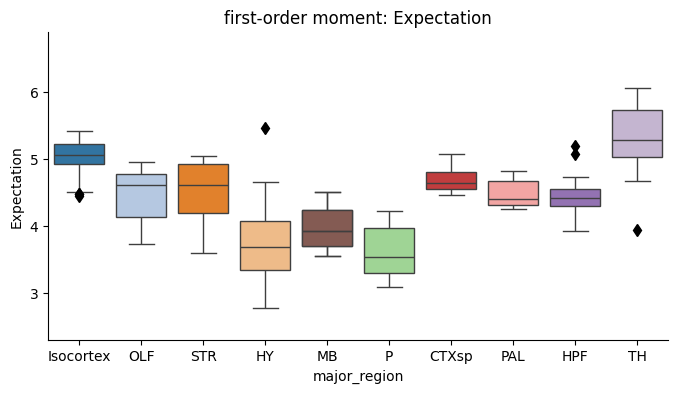

In [18]:
lambda_df2 = lambda_df2.reset_index(drop=True)
f,ax = plt.subplots(1,1,figsize=(8,4))

ax = sns.boxplot(data=lambda_df2, x='major_region', 
            y='u1', 
            order=['Isocortex', 'OLF', 'STR', 'HY', 'MB', 'P',
                   'CTXsp', 'PAL', 'HPF', 'TH', 'MB'],
            palette='tab20',
            flierprops={
                'marker': 'd',
                'markerfacecolor': 'k',
                'markeredgecolor': 'k',
                'markersize': 6
            }
           )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('first-order moment: Expectation')
plt.ylabel('Expectation')
plt.ylim([2.3, 6.9])
plt.savefig('./first-order moment_all_regions.svg', bbox_inches='tight')

C:\Users\yishui\AppData\Local\Temp\ipykernel_33980\1063919305.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=lambda_df2, x='major_region',


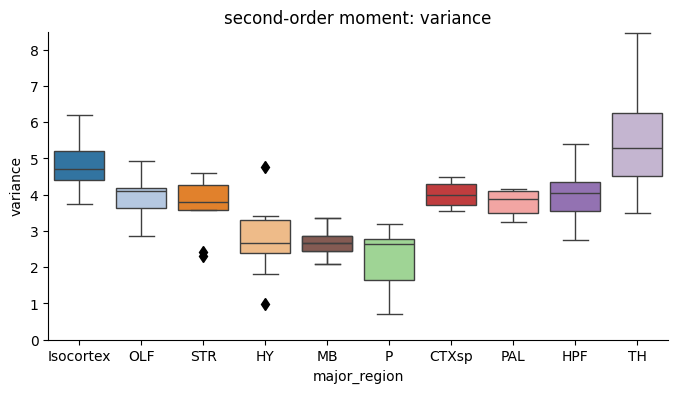

In [19]:
f,ax = plt.subplots(1,1,figsize=(8,4))

ax = sns.boxplot(data=lambda_df2, x='major_region', 
            y='u2', 
            palette='tab20',
            order=['Isocortex', 'OLF', 'STR', 'HY', 'MB', 'P',
                   'CTXsp', 'PAL', 'HPF', 'TH', 'MB'],
            flierprops={
                'marker': 'd',
                'markerfacecolor': 'k',
                'markeredgecolor': 'k',
                'markersize': 6
            }
           )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('second-order moment: variance')
plt.ylabel('variance')
plt.ylim([0, 8.5])
plt.savefig('./second-order moment variance_all_regions.svg', bbox_inches='tight')

C:\Users\yishui\AppData\Local\Temp\ipykernel_33980\2218569864.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=lambda_df2, x='major_region',


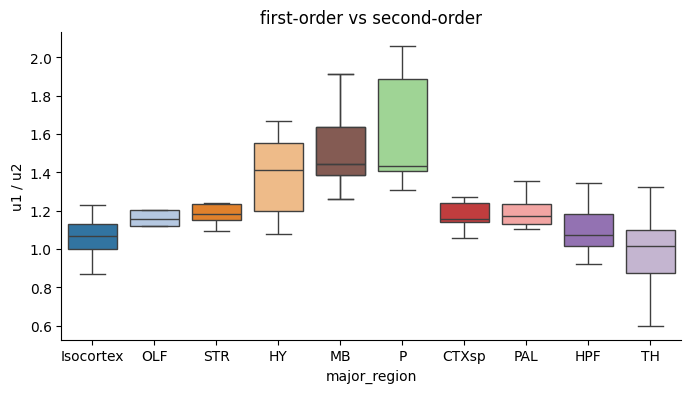

In [20]:
f,ax = plt.subplots(1,1,figsize=(8,4))

ax = sns.boxplot(data=lambda_df2, x='major_region', 
            y='u1/u2', 
            palette='tab20',
            order=['Isocortex', 'OLF', 'STR', 'HY', 'MB', 'P',
                   'CTXsp', 'PAL', 'HPF', 'TH', 'MB'],
            fliersize=0,
            flierprops={
                'marker': 'd',
                'markerfacecolor': 'k',
                'markeredgecolor': 'k',
                'markersize': 6
            },
            showfliers=False
           )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('first-order vs second-order')
plt.ylabel('u1 / u2')
# plt.ylim([0.5, 2])
plt.savefig('./cmp_moment_all_regions.svg', bbox_inches='tight')

C:\Users\yishui\AppData\Local\Temp\ipykernel_33980\3257238503.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.boxplot(data=lambda_df2, x='major_region',


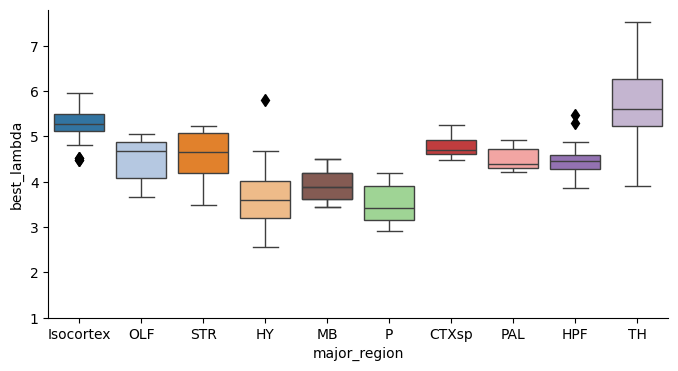

In [21]:
f,ax = plt.subplots(1,1,figsize=(8,4))

ax=sns.boxplot(data=lambda_df2, x='major_region', 
            y='best_lambda', 
            palette='tab20',
            order=['Isocortex', 'OLF', 'STR', 'HY', 'MB', 'P',
                   'CTXsp', 'PAL', 'HPF', 'TH', 'MB'],
            flierprops={
                'marker': 'd',
                'markerfacecolor': 'k',
                'markeredgecolor': 'k',
                'markersize': 6
            }
           )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([1, 7.8])

plt.savefig('./best_lambda_all_regions.svg', dpi=400, bbox_inches='tight')